# PyTorch for static regression problems

## Course on Deep Learning for System Identification
## Authors: Gabriele Maroni
## Lugano, April 22th, 2024

In this tutorial, we will address a static regression problem using PyTorch. The focus will be on several core aspects of utilizing PyTorch for neural network development and training:

1. **Defining a Custom Feed-Forward Neural Network**: We'll explore how to create a custom neural network using the `torch.nn` module. This will include setting up the network architecture with layers that are appropriate for regression tasks.

2. **Writing a Custom Training Loop**: We'll go through the steps of writing a custom training loop. This loop will manage the process of feeding data to the network, calculating loss, and updating the model parameters based on the gradient.

3. **Utilizing Dataset and DataLoader**: To efficiently manage data during training, especially when dealing with large datasets or when performing mini-batch gradient descent, we'll use PyTorch’s `Dataset` and `DataLoader` functionalities. These tools help in batching the data, shuffling, and loading it in parallel, which optimizes the training process.

By the end of this notebook, you will have a clear understanding of how to implement these components in PyTorch, which are fundamental to building and training neural network models effectively.

In [2]:
import os
from utils import *
from configs import *

import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams.update(fig_params)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2

## Global parameters

In [3]:
# Random seed value for reproducibility
SEED=42

## Data generation

The dataset that will be used in this notebook is simulated according to the following data generation mechanism [1]:

\begin{align}
x_i &\sim \mathcal{N}(0,9), \quad i=1,...,20, \\
\epsilon &\sim \mathcal{N}(0,\sigma_{\epsilon}) \\
y &= x_1 + \text{sin}(x2) + \text{log}(\left|x3\right|) + x_4^2 + x_5x_6 + \mathbb{I}(x_7x_8x_9<0) + \mathbb{I}(x_{10}>0) \\
&+ x_{11}\mathbb{I}(x_{11}>0) + \sqrt{\left|x_{12}\right|} + \text{cos}(x_{13}) + 2x_{14} + \left|x_{15}\right| + \mathbb{I}(x_{16}<-1) \\
&+ x_{17}\mathbb{I}(x_{17}<-1) - 2x_{18} - x_{19}x_{20} + \epsilon
\end{align}

In [4]:
seed_everything(SEED)

df, features, target = generate_regression_dataset(n_samples=10000,
                                                   snr_db=20, # signal to noise ratio in dB
                                                   random_seed=SEED)

df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,y
0,1.490142,-0.414793,1.943066,4.569090,-0.702460,-0.702411,4.737638,2.302304,-1.408423,1.627680,...,-1.397189,0.725887,-5.739841,-5.174753,-1.686863,-3.038493,0.942742,-2.724072,-4.236911,8.416700
1,4.396946,-0.677329,0.202585,-4.274245,-1.633148,0.332768,-3.452981,1.127094,-1.801916,-0.875081,...,5.556835,-0.040492,-3.173133,2.467635,-3.662531,0.626591,-5.879010,-3.984558,0.590584,34.299227
2,2.215400,0.514105,-0.346945,-0.903311,-4.435566,-2.159533,-1.381916,3.171367,1.030855,-5.289120,...,-1.155247,-2.030766,1.835029,3.092999,2.793840,-2.517653,-0.927637,0.993790,2.926635,15.169173
3,-1.437523,-0.556977,-3.319005,-3.588620,2.437577,4.068720,-0.216030,3.010599,1.084908,-1.935359,...,4.614110,-0.107478,4.693931,-7.859235,2.465708,0.261141,-0.897022,0.275282,-5.962707,45.150414
4,-0.659016,1.071338,4.433682,-1.554811,-2.425481,-1.505271,2.746206,0.986253,-1.589281,1.539802,...,2.905935,-2.106159,-0.982986,-1.176324,-4.390545,0.888361,0.783166,0.015340,-0.703761,9.229089


## Train-test split

In [5]:
train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=SEED)
train.shape, test.shape

((8000, 21), (2000, 21))

## Modeling: linear baseline

Starting the modeling phase with a baseline model such as a linear regression can be beneficial. It offers a simple, understandable reference point for evaluating more complex models. 
Additionally, it helps quickly identify if the problem can be reasonably addressed with basic approaches before moving to more sophisticated techniques.

### Training

In [6]:
# Model fitting
model = LinearRegression(fit_intercept=True)
model.fit(train[features], train[target]);

In [7]:
# Retrieve learned coefficients
model.coef_, model.intercept_

(array([ 1.02404228e+00, -8.28137806e-02,  4.59423025e-02, -1.15209431e-01,
         5.30317107e-02,  6.38093019e-02,  3.00733050e-02, -4.74925284e-02,
         1.13871875e-01,  9.08824702e-02,  6.34578542e-01, -1.78497898e-03,
        -1.03231940e-01,  1.93512241e+00,  7.88425890e-02, -1.17415260e-01,
         4.86494144e-01, -1.86010858e+00, -5.52177677e-02, -7.65255957e-02]),
 15.092579094702177)

### Predicting and computing evaluation metrics

In [8]:
# Train prediction
y_pred_train = model.predict(train[features])
# Test prediction
y_pred_test = model.predict(test[features])

In [9]:
# Compute evaluation metrics on train
calculate_metrics(train[target], y_pred_train)

{'mse': 321.44758245215945,
 'mae': 13.106374824163566,
 'rmse': 17.92895932429318,
 'r2': 0.20123993475692437}

In [10]:
# Compute evaluation metrics on test
calculate_metrics(test[target], y_pred_test)

{'mse': 340.95677135212856,
 'mae': 13.5326652542032,
 'rmse': 18.465014794256962,
 'r2': 0.19490461271910942}

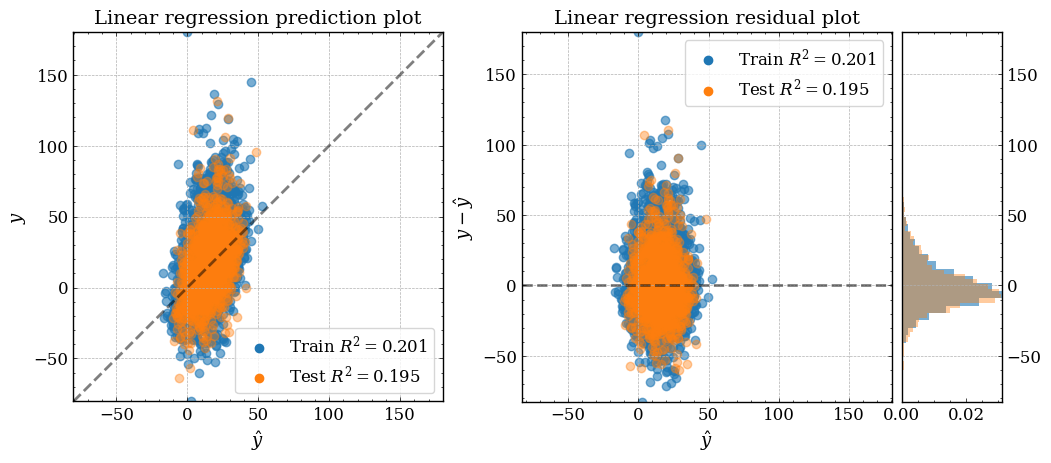

In [11]:
# Diagnosis of the results
plot_diagnostics(train[target], y_pred_train, test[target], y_pred_test, model_name='Linear regression')

From analyzing the diagnostic results, it is evident that the $R^2$ scores for both the training and test datasets are closely aligned, with the distributions of the residuals showing significant overlap. This consistency suggests that there is no overfitting in the training dataset. However, the similar but low performance metrics across both datasets also imply that the linear model is not adequately capturing the complex relationships between the features and the target variable. This indicates underfitting within the training datasets. Consequently, to better model these complexities and improve predictive accuracy, it is necessary to consider more sophisticated modeling approaches.

## Modeling: Feed Forward Neural Network

### Data pre-processing

Data normalization is a critical preprocessing step in deep learning that brings multiple advantages to model training. By ensuring all input features share a consistent scale, it prevents any single feature from dominating others, promoting stable convergence and more uniform gradient updates. This uniformity not only enhances the training efficiency and speeds up convergence but also reduces numerical instabilities like overflow or underflow, often referred to as “exploding gradients”. Additionally, normalized data smoothens the error surface, facilitating a more direct path for optimization algorithms and improving model generalization to handle new, unseen data effectively.

In [12]:
# Normalization
x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(train[features].values)
x_test = x_scaler.transform(test[features].values)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(train[target].values.reshape(-1,1))
y_test = y_scaler.transform(test[target].values.reshape(-1,1))

Converting data from numpy arrays or pandas DataFrames to PyTorch tensors is essential for training because tensors support automatic differentiation, which enables the computation of gradients during backpropagation. This feature is crucial for optimizing model parameters effectively throughout the training process.

In [13]:
# Conversion to PyTorch tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

### Defining Custom Feed-Forward Neural Networks in Pytorch

The following code blocks define three different PyTorch neural network models using the `torch.nn.Module` class. Each model is a type of feedforward neural network with slight variations in their architectures.

In [14]:
class FeedForwardNN1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN1, self).__init__()
        # First layer
        self.linear1 = nn.Linear(input_size, hidden_size)
        # ReLU activation
        self.relu = nn.ReLU()
        # Second layer
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # First layer with ReLU activation
        x = self.relu(self.linear1(x))
        # Output layer, no activation function for regression
        x = self.linear2(x)
        return x

#### FeedForwardNN1
- **Purpose**: A simple feedforward neural network with one hidden layer.
- **Initialization** (`__init__`):
  - **`input_size`**: Dimensionality of the input features.
  - **`hidden_size`**: Number of neurons in the hidden layer.
  - **`output_size`**: Number of output neurons (e.g., for regression or classification).
  - **Layers**:
    - `self.linear1`: First fully connected layer mapping from input to hidden layer.
    - `self.relu`: ReLU activation function to introduce non-linearity.
    - `self.linear2`: Second fully connected layer mapping from hidden to output layer.
- **Forward Pass** (`forward`):
  - Data `x` is passed through the first layer and ReLU activation.
  - The output of the ReLU is then passed to the second layer. Note that there's no activation function after the second layer, making this suitable for regression tasks.

In [15]:
model1 = FeedForwardNN1(input_size=x_train.shape[1],
                        hidden_size=10,
                        output_size=y_train.shape[1])
summary(model1);

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            210
├─ReLU: 1-2                              --
├─Linear: 1-3                            11
Total params: 221
Trainable params: 221
Non-trainable params: 0


In [16]:
class FeedForwardNN2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FeedForwardNN2, self).__init__()
        # First hidden layer
        self.linear1 = nn.Linear(input_size, hidden_size1)
        # Second hidden layer
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        # Output layer
        self.linear3 = nn.Linear(hidden_size2, output_size)
        # ReLU activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass through the first hidden layer and apply ReLU
        x = self.relu(self.linear1(x))
        # Pass through the second hidden layer and apply ReLU
        x = self.relu(self.linear2(x))
        # Pass through the output layer, no activation function for regression
        x = self.linear3(x)
        return x

#### FeedForwardNN2
- **Purpose**: A deeper feedforward neural network with two hidden layers.
- **Initialization** (`__init__`):
  - **`input_size`**: Dimensionality of input features.
  - **`hidden_size1` and `hidden_size2`**: The number of neurons in the first and second hidden layers, respectively.
  - **`output_size`**: Number of output neurons.
  - **Layers**:
    - `self.linear1`, `self.linear2`, and `self.linear3`: Three linear (fully connected) layers, where each successive layer connects one hidden layer to another or to the output.
    - `self.relu`: ReLU activation function to introduce non-linearity.
- **Forward Pass** (`forward`):
  - Sequentially passes data `x` through the two hidden layers with ReLU activations and then through the output layer without activation, suitable for regression.

In [17]:
model2 = FeedForwardNN2(input_size=x_train.shape[1],
                        hidden_size1=10,
                        hidden_size2=10,
                        output_size=y_train.shape[1])
summary(model2);

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            210
├─Linear: 1-2                            110
├─Linear: 1-3                            11
├─ReLU: 1-4                              --
Total params: 331
Trainable params: 331
Non-trainable params: 0


In [18]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FeedForwardNN, self).__init__()
        layers = []
        # Adding the first hidden layer that connects the input layer to the first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # Creating subsequent hidden layers
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())

        # Adding the output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        # Wrap all layers in ModuleList so they are properly registered.
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

#### FeedForwardNN
- **Purpose**: A modular and scalable model with a variable number of hidden layers.
- **Initialization** (`__init__`):
  - **`input_size`**: Dimensionality of input features.
  - **`hidden_sizes`**: A list specifying the number of neurons in each hidden layer.
  - **`output_size`**: Number of output neurons.
  - **Layers**:
    - Dynamically creates layers based on the `hidden_sizes` list.
    - Uses a combination of `nn.Linear` and `nn.ReLU` for each hidden layer.
    - `self.layers`: `nn.ModuleList` wraps the layers ensuring proper parameter registration and handling within PyTorch’s optimization framework.
- **Forward Pass** (`forward`):
  - Iteratively processes data `x` through each layer (both `nn.Linear` and `nn.ReLU`) in the `self.layers` list, allowing for flexibility in handling different numbers of layers and complex architectures.

In [19]:
model = FeedForwardNN(input_size=x_train.shape[1],
                      hidden_sizes=[10,10],
                      output_size=y_train.shape[1])
summary(model);

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Linear: 2-1                       210
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       110
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       11
Total params: 331
Trainable params: 331
Non-trainable params: 0


### Training set-up

In [20]:
seed_everything(SEED)

# Instantiate the model
model = FeedForwardNN(input_size=x_train.shape[1],
                      hidden_sizes=[20,20],
                      output_size=y_train.shape[1])
print(f"Total number of trainable model parameters: {get_model_num_params(model)}")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define loss function
loss_function = nn.MSELoss()

# Calculate loss value with untrained model to use as reference
y_pred_train = model(x_train)
loss0 = loss_function(y_pred_train, y_train).item()
print(f"Initial loss: {loss0:.5f}")

Total number of trainable model parameters: 861
Initial loss: 1.00438


### Training loop

In [21]:
# Set the number of epoch, which determines the number of training iterations. Each epoch represents a complete pass over the entire training dataset.
epochs = 10000

for epoch in range(epochs):
    # Forward pass
    y_pred_train = model(x_train) # Compute predicted y by passing x to the model
    
    loss = loss_function(y_pred_train, y_train) # Compute the loss
    
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad() # Clear the gradients before backward pass to not accumulate gradients over multiple iterations.
                          # You can thus call optimizer.zero_grad() everywhere in the loop 
                          # but not between the loss.backward() and optimizer.step() operation.
                          # If so, you would get the loss=0, while nothing's ever learnt
    loss.backward() # Backpropagation: computes the gradient of the loss with respect to the model parameters.
    optimizer.step() # Update parameters: adjusts the model parameters based on the computed gradients.
    
    # Logging the loss
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:03d}/{epochs:03d}"
              f" | Train Loss: {loss:.5f}")

# Optionally, evaluate the model performance
with torch.no_grad():
    y_pred_train = model(x_train)
    final_loss = loss_function(y_pred_train, y_train)
    print(f'Final Loss: {final_loss.item():.5f}')

Epoch: 000/10000 | Train Loss: 1.00438
Epoch: 100/10000 | Train Loss: 0.97238
Epoch: 200/10000 | Train Loss: 0.93405
Epoch: 300/10000 | Train Loss: 0.88277
Epoch: 400/10000 | Train Loss: 0.81861
Epoch: 500/10000 | Train Loss: 0.74706
Epoch: 600/10000 | Train Loss: 0.67746
Epoch: 700/10000 | Train Loss: 0.60951
Epoch: 800/10000 | Train Loss: 0.53699
Epoch: 900/10000 | Train Loss: 0.45676
Epoch: 1000/10000 | Train Loss: 0.37213
Epoch: 1100/10000 | Train Loss: 0.28989
Epoch: 1200/10000 | Train Loss: 0.21827
Epoch: 1300/10000 | Train Loss: 0.16398
Epoch: 1400/10000 | Train Loss: 0.12838
Epoch: 1500/10000 | Train Loss: 0.10744
Epoch: 1600/10000 | Train Loss: 0.09567
Epoch: 1700/10000 | Train Loss: 0.08873
Epoch: 1800/10000 | Train Loss: 0.08433
Epoch: 1900/10000 | Train Loss: 0.08108
Epoch: 2000/10000 | Train Loss: 0.07841
Epoch: 2100/10000 | Train Loss: 0.07616
Epoch: 2200/10000 | Train Loss: 0.07402
Epoch: 2300/10000 | Train Loss: 0.07204
Epoch: 2400/10000 | Train Loss: 0.07018
Epoch: 250

### Predicting and computing evaluation metrics

In [22]:
### FIRST OPTION:
# Train prediction
y_pred_train = model(x_train)
# Test prediction
y_pred_test = model(x_test)

# Invert scaling operation
y_pred_train = y_scaler.inverse_transform(y_pred_train.detach().numpy())
y_pred_test = y_scaler.inverse_transform(y_pred_test.detach().numpy())

### SECOND OPTION:
# with torch.no_grad():
#     # Train prediction
#     y_pred_train = model(x_train)
#     # Test prediction
#     y_pred_test = model(x_test)
    
#     # Invert scaling operation
#     y_pred_train = y_scaler.inverse_transform(y_pred_train.numpy())
#     y_pred_test = y_scaler.inverse_transform(y_pred_test.numpy())

#### First Option: Without `torch.no_grad()`
- **Gradient Tracking**: By default, PyTorch tracks operations on tensors for gradient computation. Even if you are just making predictions, without `with torch.no_grad()`, the tensors produced (like `y_pred_train` and `y_pred_test`) will have their computational graph retained, and PyTorch will keep track of any operations performed on them. This uses more memory and computation.
- **Detaching and Converting to NumPy**: You detach the tensors from the computational graph using `.detach()` before converting them to NumPy arrays. This prevents PyTorch from tracking further operations, which is necessary to move the data to a library like NumPy that does not understand PyTorch gradients.

#### Second Option: Using `with torch.no_grad()`
- **Disabling Gradient Computation**: The `with torch.no_grad():` block explicitly stops PyTorch from tracking operations on tensors. This means that during inference, the tensors do not track gradients, reducing memory usage and computational overhead.
- **Direct Conversion to NumPy**: Inside the `with torch.no_grad():` block, since gradients are not being tracked, there is no need to call `.detach()` on the tensors before converting them to NumPy arrays. You can directly convert the tensors to NumPy, which simplifies the code and maintains lower memory usage.

In [23]:
calculate_metrics(train[target], y_pred_train)

{'mse': 8.170547554695704,
 'mae': 2.253035022614478,
 'rmse': 2.8584169665560872,
 'r2': 0.979697134294573}

In [24]:
calculate_metrics(test[target], y_pred_test)

{'mse': 10.834867694071654,
 'mae': 2.6032741262752266,
 'rmse': 3.291636020897762,
 'r2': 0.9744158123984378}

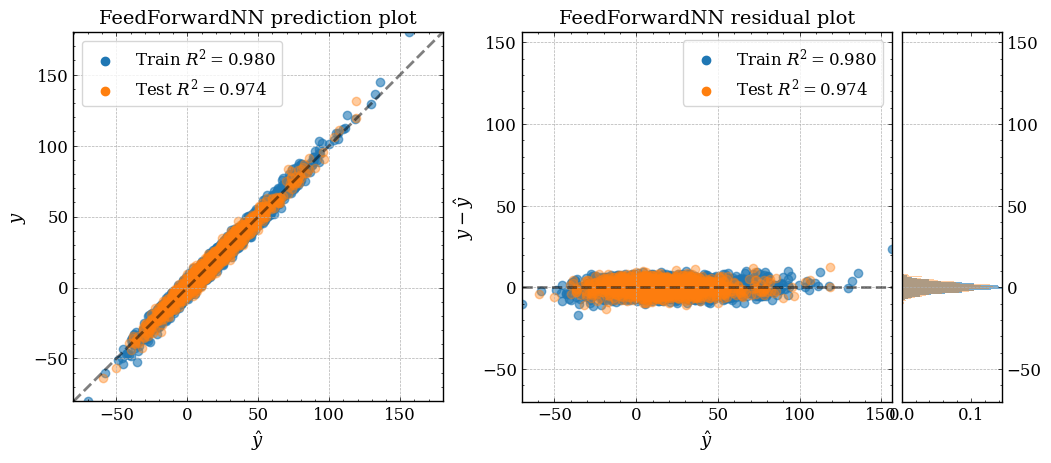

In [25]:
# Diagnosis of the results
plot_diagnostics(train[target], y_pred_train, test[target], y_pred_test, model_name='FeedForwardNN')

From analyzing the results, it is evident that the feedforward neural network, in contrast to the linear model, successfully captures the strong non-linearities inherent in the dataset.

## Dataset and Dataloader

Utilizing PyTorch’s Dataset and DataLoader functionalities is useful for managing data effectively during the training of machine learning models, particularly when dealing with large datasets or when implementing mini-batch gradient descent. The `Dataset` class provides a structured way to encapsulate any type of data, be it images, text, or tabular data into a format that can be easily manipulated and passed through machine learning models. This encapsulation allows for the isolation of data preprocessing steps from the model training logic, making the code more modular and easier to maintain.

The `DataLoader`, on the other hand, enhances the training process by automating the retrieval of data samples from a `Dataset` in batches. This is particularly important for training on large datasets that do not fit into memory all at once. By training the model on smaller subsets or "mini-batches," mini-batch gradient descent allows for both memory efficiency and faster convergence by updating model parameters iteratively after each batch rather than waiting to process the entire dataset.

Moreover, `DataLoader` supports shuffling of the data at the beginning of each training epoch, which prevents the model from learning patterns based on the order of the data, thus helping to avoid overfitting and ensuring better model generalization. Parallel data loading is another significant feature provided by `DataLoader`, leveraging multiple worker processes to load data simultaneously. This parallelism significantly reduces the time the model spends waiting for data to be ready, thereby optimizing the overall training time.

In [26]:
class RegressionDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

#### Custom Dataset Class `RegressionDataset`

- **Class Definition**: `RegressionDataset` inherits from PyTorch's `Dataset` class, which is a part of the `torch.utils.data` module. This inheritance makes `RegressionDataset` compatible with other PyTorch utilities like `DataLoader`.

- **Constructor `__init__`**:
  - The constructor takes two arguments: `x` and `y`. These are typically numpy arrays, PyTorch tensors, or lists containing the input features (`x`) and the target outputs (`y`) respectively.
  - `self.x` and `self.y` are assigned to store these inputs and outputs within the dataset object.

- **`__len__` Method**:
  - This method returns the number of examples in the dataset by returning the length of `self.x`. This is essential for the `DataLoader` to determine the size of the dataset.

- **`__getitem__` Method**:
  - Takes an index `idx` and returns a tuple containing the input features and target output for the corresponding example. This method is called by the `DataLoader` to fetch batches of data.

In [27]:
batch_size = 64

# Datasets
train_dataset = RegressionDataset(x_train, y_train)
test_dataset = RegressionDataset(x_test, y_test)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=False)

#### Data Loaders

- **`batch_size` Variable**: 
  - A variable `batch_size` is set to 64, indicating the number of samples included in each batch when the `DataLoader` retrieves data.

- **DataLoader Instances**:
  - **Training DataLoader (`train_loader`)**: Configured to load data from `train_dataset`. It uses the specified `batch_size` and shuffles the data (`shuffle=True`) to ensure that each epoch receives the data in a different order, which helps in improving model generalization. `drop_last=True` is used to discard the last batch in each epoch if it's smaller than the specified `batch_size`, ensuring that all batches have the same size.
  - **Testing DataLoader (`test_loader`)**: Configured similarly but with `shuffle=False`, as shuffling is generally not required during testing or validation because it does not affect the outcome but can make results non-reproducible if the test data is randomized.

Choosing the batch size for training a neural network is a critical decision that can significantly influence the training dynamics, performance, and computational efficiency. There is no one-size-fits-all answer; instead, the optimal batch size often depends on several factors, including the specific problem, the architecture of the model, and the hardware available. Here are some key considerations and strategies to help determine the best batch size for your needs:

#### 1. **Memory Constraints**
- **Hardware Limits**: The primary constraint is often the amount of GPU or CPU memory available. Larger batch sizes require more memory since more data must be processed simultaneously. You need to choose a batch size that your hardware can handle without running out of memory.

#### 2. **Training Stability and Performance**
- **Generalization vs. Speed**: Larger batch sizes can lead to faster epoch times as you're processing more data simultaneously, leveraging efficient parallel hardware computations. However, larger batches might reduce the model's ability to generalize well to unseen data. This happens because large batch sizes provide a more accurate estimate of the gradient, which might lead to convergence to sharp minima that do not generalize well.
- **Small Batch Sizes**: Training with smaller batch sizes has been observed to provide a regularizing effect and better generalization. However, very small batches can lead to a noisy gradient estimate, which might make the training process unstable and increase the time to converge.

#### 3. **Empirical Heuristics**
- **Rule of Thumb**: A common practice is to try a range of batch sizes, such as 32, 64, 128, 256, and so on. Monitor the training performance for each size and select the one that offers the best compromise between training speed and model accuracy.
- **Powers of Two**: Batch sizes that are powers of two (e.g., 32, 64, 128) are often recommended due to the way memory is structured in most computing hardware, potentially leading to more efficient processing.

#### 4. **Learning Dynamics**
- **Batch Size and Learning Rate**: The batch size can affect the optimal learning rate. Larger batches typically require a higher learning rate since the gradient estimate is less noisy. Techniques like learning rate scaling can be helpful; for instance, linear scaling rule suggests scaling the learning rate in proportion to the batch size.

In [28]:
for x_train_batch, y_train_batch in train_loader:
    print(x_train_batch.shape, y_train_batch.shape)
    break

torch.Size([64, 20]) torch.Size([64, 1])


### Training set-up

In [29]:
seed_everything(SEED)

# Instantiate the model
model = FeedForwardNN(input_size=x_train.shape[1],
                      hidden_sizes=[20,20],
                      output_size=y_train.shape[1])
print(f"Total number of trainable model parameters: {get_model_num_params(model)}")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define loss function
loss_function = nn.MSELoss()

# Calculate loss value with untrained model to use as reference
y_pred_train = model(x_train)
loss0 = loss_function(y_pred_train, y_train).item()
print(f"Initial loss: {loss0:.5f}")

Total number of trainable model parameters: 861
Initial loss: 1.00438


### Training loop

In [30]:
# Number of epochs
epochs = 1000

# Training loop
for epoch in range(epochs):
    # Training
    loss = 0.0
    for x_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()
        y_pred_train_batch = model(x_train_batch)
        loss_batch = loss_function(y_pred_train_batch, y_train_batch)
        loss_batch.backward()
        optimizer.step()
        loss += loss_batch.item() * x_train_batch.size(0)

    # Average loss
    loss /= train.shape[0]

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:03d}/{epochs:03d}"
              f" | Train Loss: {loss:.5f}")

Epoch: 000/1000 | Train Loss: 0.99513
Epoch: 100/1000 | Train Loss: 0.06182
Epoch: 200/1000 | Train Loss: 0.04147
Epoch: 300/1000 | Train Loss: 0.03194
Epoch: 400/1000 | Train Loss: 0.02733
Epoch: 500/1000 | Train Loss: 0.02505
Epoch: 600/1000 | Train Loss: 0.02369
Epoch: 700/1000 | Train Loss: 0.02275
Epoch: 800/1000 | Train Loss: 0.02208
Epoch: 900/1000 | Train Loss: 0.02162


### Predicting and computing evaluation metrics

In [31]:
### FIRST OPTION:
with torch.no_grad():
    # Train prediction
    y_pred_train = model(x_train)
    # Test prediction
    y_pred_test = model(x_test)
    
    # Invert scaling operation
    y_pred_train = y_scaler.inverse_transform(y_pred_train.numpy())
    y_pred_test = y_scaler.inverse_transform(y_pred_test.numpy())

# ### SECOND OPTION:
# y_pred_test = np.empty(0)
# with torch.no_grad(): 
#     for x_test_batch, _ in test_loader:
#         y_pred_test_batch = model(x_test_batch)
#         y_pred_test = np.append(y_pred_test, y_pred_test_batch.numpy())
# y_pred_test = y_scaler.inverse_transform(y_pred_test.reshape(-1,1))

In [32]:
calculate_metrics(train[target], y_pred_train)

{'mse': 8.429396147024622,
 'mae': 2.299410587580694,
 'rmse': 2.9033422373231548,
 'r2': 0.9790539254798745}

In [33]:
calculate_metrics(test[target], y_pred_test)

{'mse': 11.675842612066587,
 'mae': 2.6883807913586253,
 'rmse': 3.4169932121774234,
 'r2': 0.9724300327214083}

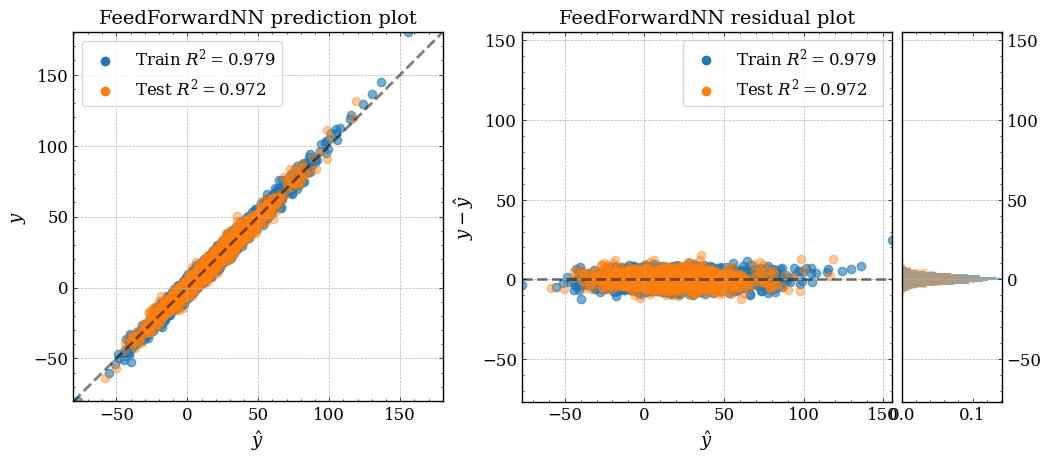

In [34]:
# Diagnosis of the results
plot_diagnostics(train[target], y_pred_train, test[target], y_pred_test, model_name='FeedForwardNN')

## Exercise

Familiarize with the code, experiment with different:
- number of hidden layers
- number of neurons
- optimizers
- learning rates
- epochs number.

## References

[1] Kuhn, M. and Johnson, K., 2019. Feature engineering and selection: A practical approach for predictive models. Chapman and Hall/CRC.